# Exploratory Data Analysis - EL2

## 1. Loading packages and libraries

We'll start by importing the necessary packages

In [7]:
# For data manipulation
import pandas as pd
import numpy as np

# For visualisations
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates

# For UML
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## 2. Loading data

Next we'll load the EL1 dataset from the data folder.

This dataset contains data from one sensor installed at an electric charger spot.

The information received about the columns are the following:
*	**Time:** Time of measurement
*	**Battery:** Battery voltage at packet transmission (the nominal voltage of the battery package is 3V, and the capacity is 6AH)
*   **Temperature:** Calibrates the magnetic field readings, which are highly dependent on the temperature
*	**X:** Magnetic field reading in the x direction
*	**Y:** Magnetic field reading in the y direction
*	**Z:** Magnetic field reading in the z direction
*   **Radar data:**
    *   **0_radar:** Signal reflection strength in the 20 – 27.5 cm
    *	**1_radar:** Signal reflection strength in the 27.5 – 35 cm
    *	**2_radar:** Signal reflection strength in the 35 – 42.5 cm
    *	**3_radar:** Signal reflection strength in the 42.5 – 50 cm
    *	**4_radar:** Signal reflection strength in the 50 – 57.5 cm
    *	**5_radar:** Signal reflection strength in the 57.5 – 65 cm
    *	**6_radar:** Signal reflection strength in the 65 – 72.5 cm
    *	**7_radar:** Signal reflection strength in the 72.5 – 80 cm
*	**Package_type:**
    *	**PackageType.CHANGE =** A big change in magnetic field is detected. The magnetic field coordinates (x, y and z) need to change by 30 points on at least 1 axis, to be classified as a CHANGE packet.
    *	**PackageType.HEART_BEAT =** Regular heartbeat if no major changes in magnetic field are detected
*	**f_cnt:** The number of packages transmitted since last network registration
*	**dr:** Data rate parameter in LoRaWAN. It ranges between 1 and 5 where 1 is the slowest transmission data rate and 5 is the highest. This datarate is scaled by the network server depending on the signal quality of the past packages send.
*	**SNR:** Signal to noise ratio – the higher value, the better the signal quality
*	**RSSI:** Signal strength – the higher value, the better the signal quality

In [8]:
# Loading the data
df = pd.read_csv('/work/MLOps_Project/data/EL2.csv') # The path to the dataset should probably be changed when we're setting up the serverless-ml-pipeline
df.head()

,time,battery,temperature,x,y,z,0_radar,1_radar,2_radar,3_radar,4_radar,5_radar,6_radar,7_radar,package_type,f_cnt,dr,snr,rssi
0,2024-02-13 11:53:30.800,3.12,15.62,620,-618,-532,10,5,6,6,7,7,5,5,PackageType.CHANGE,214,0,5.8,-106
1,2024-02-13 12:07:56.910,3.14,16.38,525,-631,-557,9,6,4,5,6,6,5,4,PackageType.CHANGE,215,0,7.2,-108
2,2024-02-13 12:17:54.246,3.14,16.38,515,-630,-543,10,5,5,5,8,7,5,4,PackageType.HEART_BEAT,216,0,-4.2,-102
3,2024-02-13 12:27:55.246,3.14,16.88,508,-625,-541,10,5,5,5,8,7,5,4,PackageType.HEART_BEAT,216,0,-4.2,-102
4,2024-02-13 12:37:57.246,3.14,17.25,501,-627,-529,10,5,5,5,8,7,5,4,PackageType.HEART_BEAT,216,0,-4.2,-102


## 3. Checking for missing values and duplicates

In [9]:
# Checking for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6314 entries, 0 to 6313
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   time          6314 non-null   object 
 1   battery       6314 non-null   float64
 2   temperature   6314 non-null   float64
 3   x             6314 non-null   int64  
 4   y             6314 non-null   int64  
 5   z             6314 non-null   int64  
 6   0_radar       6314 non-null   int64  
 7   1_radar       6314 non-null   int64  
 8   2_radar       6314 non-null   int64  
 9   3_radar       6314 non-null   int64  
 10  4_radar       6314 non-null   int64  
 11  5_radar       6314 non-null   int64  
 12  6_radar       6314 non-null   int64  
 13  7_radar       6314 non-null   int64  
 14  package_type  6314 non-null   object 
 15  f_cnt         6314 non-null   int64  
 16  dr            6314 non-null   int64  
 17  snr           6314 non-null   float64
 18  rssi          6314 non-null 

Here we see that there are no missing values. We can also see the name of each column and what kind of datatype they contain. 

There are 3 columns containing floats, which are floating point numbers, 14 columns contain integers, which are integer numbers and lastly there are 2 columns containing objects, which is text or mixed numeric and non-numeric values.

The time column is at the moment classified as an object. We'll transform this column to a datetime format.

In [10]:
# Changing the time column to datetime
df['time'] = pd.to_datetime(df['time'])

# Checking the datatype of each column again
df.dtypes

time            datetime64[ns]
battery                float64
temperature            float64
x                        int64
y                        int64
z                        int64
0_radar                  int64
1_radar                  int64
2_radar                  int64
3_radar                  int64
4_radar                  int64
5_radar                  int64
6_radar                  int64
7_radar                  int64
package_type            object
f_cnt                    int64
dr                       int64
snr                    float64
rssi                     int64
dtype: object

We can see that the 'time' variable has changed from object to datetime64

In [11]:
# Checking how the time column looks now
df['time'].head()

0   2024-02-13 11:53:30.800
1   2024-02-13 12:07:56.910
2   2024-02-13 12:17:54.246
3   2024-02-13 12:27:55.246
4   2024-02-13 12:37:57.246
Name: time, dtype: datetime64[ns]

Now we'll check for any duplicated rows in the dataset

In [12]:
# Checking if there are any duplicated rows
num_duplicate_rows = df.duplicated().sum()
print("Number of duplicated rows: ", num_duplicate_rows)

Number of duplicated rows:  0


This tells us that there are no duplicated rows.

We'll also check the number of unique values in each column:

In [13]:
# Checking the number of unique values in each column
df.nunique()

time            6314
battery            4
temperature      217
x                575
y                611
z                913
0_radar          197
1_radar          184
2_radar          177
3_radar          138
4_radar          104
5_radar           73
6_radar           50
7_radar           41
package_type       2
f_cnt           2601
dr                 6
snr               80
rssi              36
dtype: int64

## 4. Feature Engineering

Before starting on the EDA, we'll make some extra features in order to get more information about the data.

In [14]:
# Making a new column including only the date from the 'time' variable
df['date'] = df['time'].dt.date

In [15]:
# Making a new column including only the hour from the 'time' variable
df['hour'] = df['time'].dt.hour

In [16]:
# Making a new column including the day of week from the 'time' variable
df['day_of_week'] = df['time'].dt.dayofweek

# And another column containing the name of the day
df['day_name'] = df['time'].dt.day_name()

In [17]:
# Checking how these new variables look
df[['time','date', 'hour', 'day_of_week', 'day_name']].sample(10)

,time,date,hour,day_of_week,day_name
1195,2024-02-27 12:50:17.284,2024-02-27,12,1,Tuesday
5617,2024-03-27 03:02:34.922,2024-03-27,3,2,Wednesday
2665,2024-03-07 05:20:28.449,2024-03-07,5,3,Thursday
2953,2024-03-09 06:29:48.505,2024-03-09,6,5,Saturday
1687,2024-03-01 06:37:17.140,2024-03-01,6,4,Friday
3397,2024-03-12 08:36:04.046,2024-03-12,8,1,Tuesday
2637,2024-03-07 00:40:28.062,2024-03-07,0,3,Thursday
1906,2024-03-02 19:06:12.864,2024-03-02,19,5,Saturday
3561,2024-03-13 11:33:52.161,2024-03-13,11,2,Wednesday
5402,2024-03-25 14:30:39.442,2024-03-25,14,0,Monday


## 5. Exploratory Data Analysis

Now we'll start on the EDA. Firstly, we'll look at the descriptive statistics for all of the numeric columns. For this we'll use the pandas describe command.

In [18]:
# Generating descriptive statistics
df.describe()

,time,battery,temperature,x,y,z,0_radar,1_radar,2_radar,3_radar,4_radar,5_radar,6_radar,7_radar,f_cnt,dr,snr,rssi,hour,day_of_week
count,6314,6314.000000,6314.000000,6314.000000,6314.000000,6314.000000,6314.000000,6314.000000,6314.000000,6314.000000,6314.000000,6314.000000,6314.000000,6314.000000,6314.000000,6314.000000,6314.000000,6314.000000,6314.000000,6314.000000
mean,2024-03-10 19:44:13.167758592,3.111897,6.601403,690.365537,-613.704466,-632.736459,31.324834,28.799810,26.523915,21.093602,17.449477,12.312639,10.000475,8.156794,1888.337187,4.843047,8.264539,-97.921286,11.448052,2.943934
min,2024-02-13 11:53:30.800000,3.100000,-2.750000,151.000000,-1195.000000,-1295.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,214.000000,0.000000,-8.800000,-121.000000,0.000000,0.000000
25%,2024-02-29 10:41:06.976500224,3.100000,4.250000,643.000000,-652.000000,-738.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1232.250000,5.000000,7.500000,-103.000000,6.000000,1.000000
50%,2024-03-10 16:33:50.480999936,3.100000,6.120000,709.000000,-636.000000,-628.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,1931.000000,5.000000,9.000000,-96.000000,11.000000,3.000000
75%,2024-03-20 23:12:23.476499968,3.120000,8.120000,758.000000,-614.000000,-513.000000,12.000000,8.000000,7.000000,7.000000,7.750000,8.000000,8.000000,7.000000,2601.750000,5.000000,9.800000,-91.000000,17.000000,5.000000
max,2024-03-31 23:38:59.083000,3.160000,25.750000,1170.000000,400.000000,577.000000,255.000000,255.000000,252.000000,249.000000,139.000000,100.000000,68.000000,45.000000,3199.000000,5.000000,13.500000,-86.000000,23.000000,6.000000
std,NaN,0.013578,4.439063,109.742817,156.775839,198.139478,54.097106,48.350761,42.795849,31.960423,23.727953,13.995682,9.495937,6.473780,798.977454,0.764475,2.251435,7.412640,6.730769,1.968956


Next we'll check the number of datapoints each day

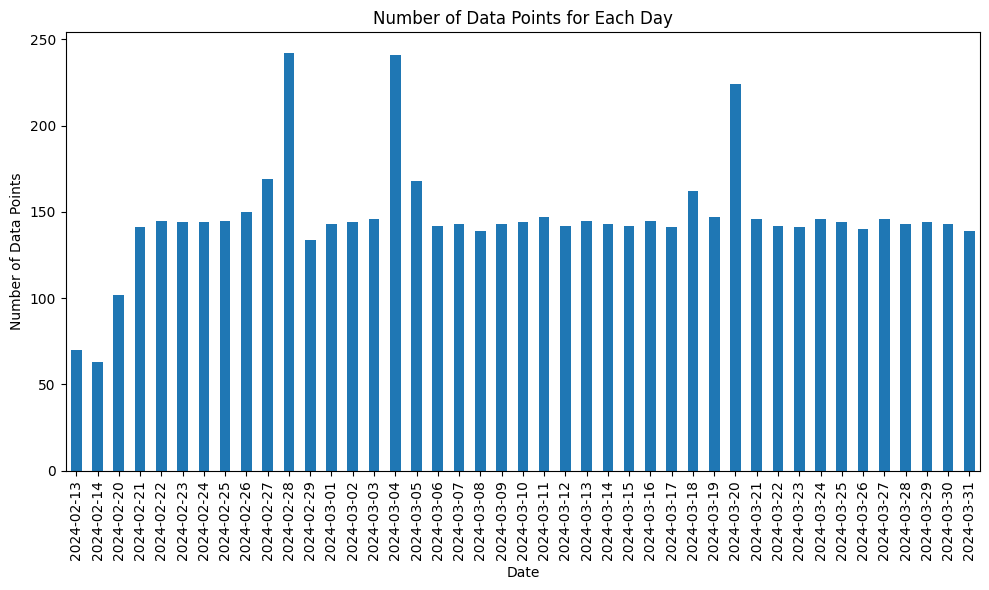

In [19]:
# Grouping by date and counting the number of data points
daily_counts = df.groupby('date').size()

# Plotting the number of data points for each day using plt
plt.figure(figsize=(10, 6))
daily_counts.plot(kind='bar')
plt.title('Number of Data Points for Each Day')
plt.xlabel('Date')
plt.ylabel('Number of Data Points')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Here we can see that there are most datapoints from the 27th and 28th of February and that there are fewer datapoints from the 13th and 14th of February. 

We can also see that there are no datapoints from the 15th-19th of February as there is a gap between 2024-02-14 and 2024-02-20. Perhaps the sensor for this parking spot has broken down a few days.

### Package type variable

Next we'll look at the package type variable. Firstly we'll check which unique values the variable contains.

In [20]:
# Checking the unique values in package type
df['package_type'].unique()

array(['PackageType.CHANGE', 'PackageType.HEART_BEAT'], dtype=object)

We now know that the variable contains two unique values; Package.Type.CHANGE and PackageType.HEART_BEAT.

From the information about the dataset we know that CHANGE is used for datapoints where a big change in magnetic field is detected and HEART_BEAT is used when there is no major changes in the magnetic field.

We can check the distribution of these two package types.

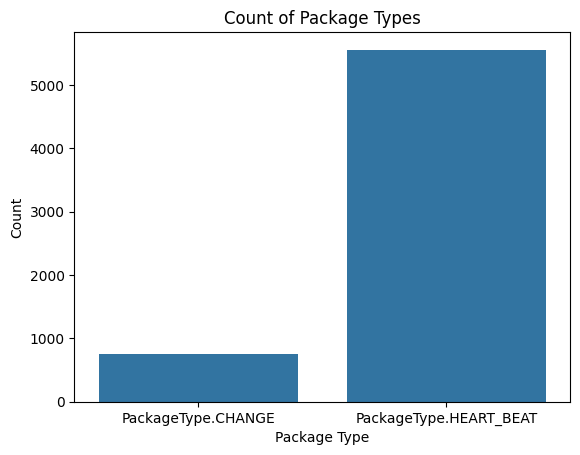

In [21]:
# Plotting the distribution of package types
plt.figure()
sns.countplot(data=df, x='package_type')
plt.title('Count of Package Types')
plt.xlabel('Package Type')
plt.ylabel('Count')
plt.show()

In this plot we can see that there are more datapoints classified as CHANGE than there are HEART_BEAT. As CHANGE represents big changes in the magnetic field, we'll assume that this class represents when a vehicle either parks or leaves the parking spot.

We'll also check if the distribution of package type varies by hour of day.

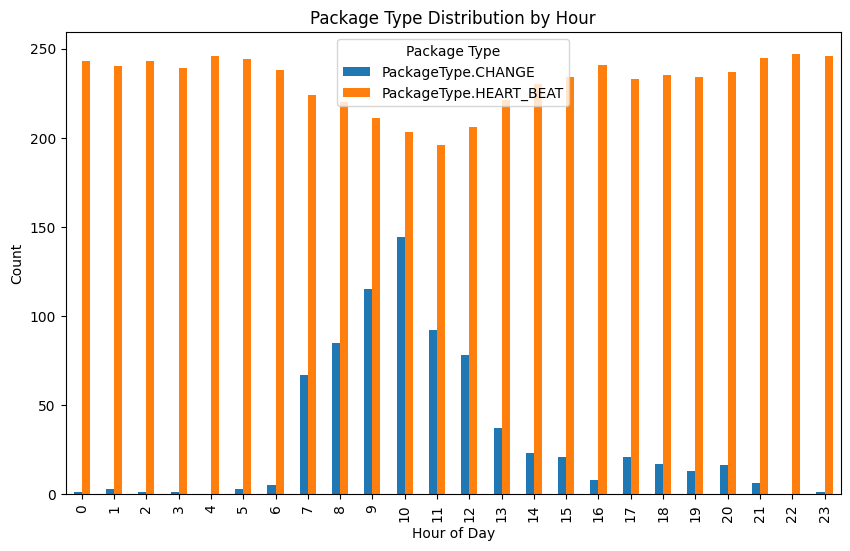

In [22]:
# Grouping the package type based on hour
hourly_counts = df.groupby(['hour', 'package_type']).size().unstack(fill_value=0)

# Plotting the package type distribution by hour
hourly_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Package Type Distribution by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.legend(title='Package Type')
plt.show()

This plot tells us that there are more changes in the parking lot between 04:00 and 12:00. This might indicate that there are more people charging their battery driven cars in this time slot. 

We'll also look at the distribution by day of week.

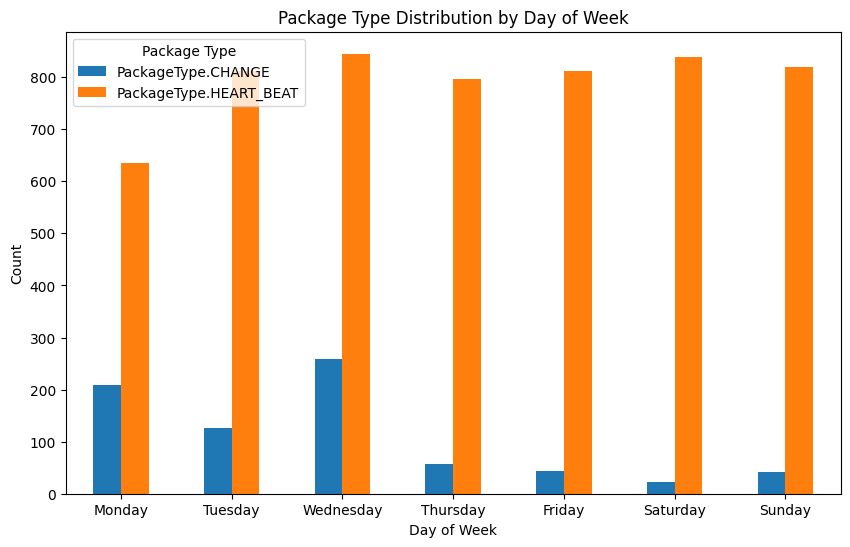

In [23]:
# Grouping the package type based on day of week
day_of_week_counts = df.groupby(['day_name', 'package_type']).size().unstack(fill_value=0)

# Specifying the order of days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Reordering the index based on the specified day order
day_of_week_counts = day_of_week_counts.reindex(day_order)

# Plotting the package type distribution by day of week
day_of_week_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Package Type Distribution by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.legend(title='Package Type')
plt.xticks(rotation=0)
plt.show()

This plot indicates that there are more people charging their cars on tuesdays and wednesday. 

We would also like to know how long the car is parked on average.

In [24]:
# Creating two new dataframes. The first dataframe is filtered to only include PackageType.CHANGE events and the second dataframe wil only include PackageType.HEART_BEAT
changes = df[df['package_type'] == 'PackageType.CHANGE']
heart_beats = df[df['package_type'] == 'PackageType.HEART_BEAT']

In [25]:
# Calculating parking duration for each change
changes = changes.copy()  # Creating a copy of the dataframe to get rid of warnings
changes['parking_duration'] = changes['time'].diff()

# Calculating the average parking duration
average_parking_duration = changes['parking_duration'].mean()

print("Average parking duration:", average_parking_duration)

Average parking duration: 0 days 01:27:36.227694848


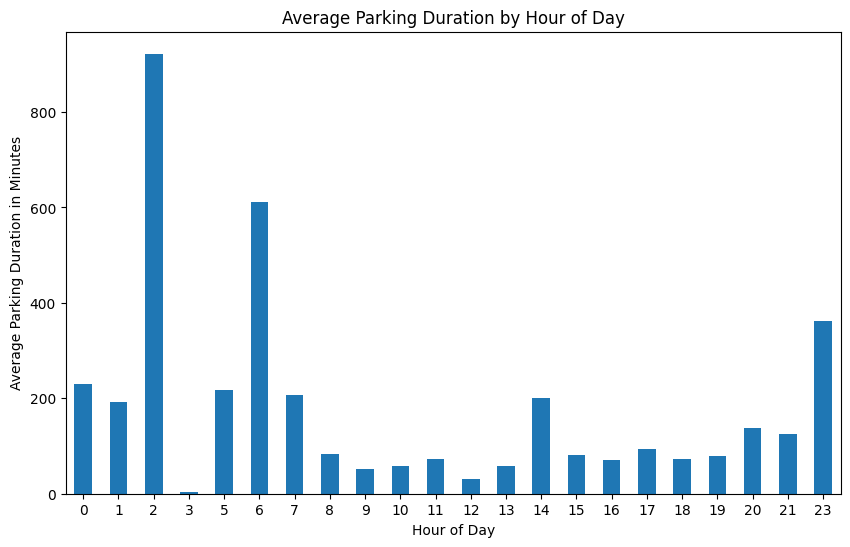

In [26]:
# Calculating parking duration in minutes for each change
changes['parking_duration_minutes'] = changes['parking_duration'].dt.total_seconds() / 60

# Grouping by hour and calculating the mean parking duration in minutes
hourly_avg_parking_duration = changes.groupby('hour')['parking_duration_minutes'].mean()

# Plotting the average parkign duration by hour of day
plt.figure(figsize=(10, 6))
hourly_avg_parking_duration.plot(kind='bar')
plt.title('Average Parking Duration by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Parking Duration in Minutes')
plt.xticks(rotation=0)
plt.show()

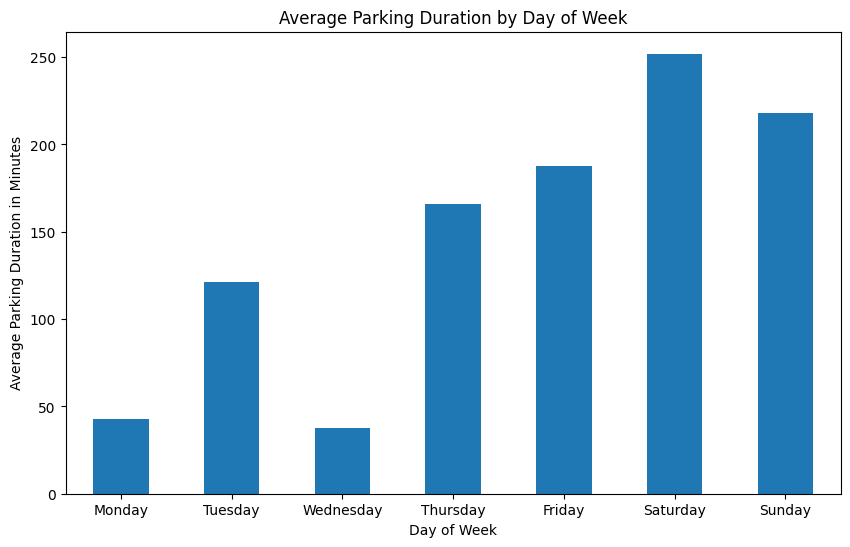

In [27]:
# Grouping by hour and calculating the mean parking duration in minutes
daily_avg_parking_duration = changes.groupby('day_name')['parking_duration_minutes'].mean()

# Reordering the index based on the specified day order from before
daily_avg_parking_duration = daily_avg_parking_duration.reindex(day_order)

# Plotting the average parkign duration by hour of day
plt.figure(figsize=(10, 6))
daily_avg_parking_duration.plot(kind='bar')
plt.title('Average Parking Duration by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Parking Duration in Minutes')
plt.xticks(rotation=0)
plt.show()

Correlation between package type and magnetic field

In [28]:
# Convert 'package_type' to numeric codes
df['package_type_encoded'] = pd.Categorical(df['package_type']).codes
df['package_type_encoded'].head()

0    0
1    0
2    1
3    1
4    1
Name: package_type_encoded, dtype: int8

PackageType.CHANGE is now represented by 0 and PackageType.HEART_BEAT is represented by 1

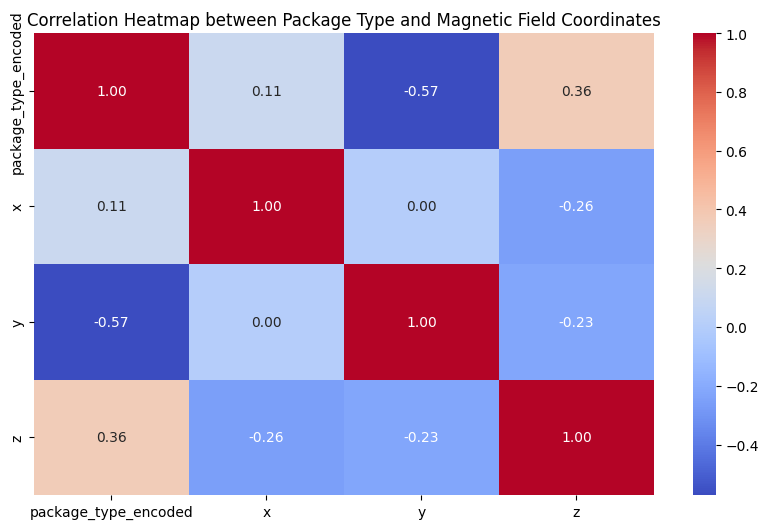

In [29]:
# Calculating correlation matrix
correlation_matrix = df[['package_type_encoded', 'x', 'y', 'z']].corr()

# Plotting heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between Package Type and Magnetic Field Coordinates')
plt.show()

Before going on to the next variable, we'll look at how much x, y and z need to change in order for the package type to change from HEART_BEAT to CHANGE.

In [30]:
df_package_diff = df[['time', 'x', 'y', 'z', 'package_type']]
df_package_diff = df_package_diff.copy() # Making a copy of the dataframe to get rid of warnings
df_package_diff['x_diff'] = df_package_diff['x'].diff()
df_package_diff['y_diff'] = df_package_diff['y'].diff()
df_package_diff['z_diff'] = df_package_diff['z'].diff()
df_package_diff.head()

,time,x,y,z,package_type,x_diff,y_diff,z_diff
0,2024-02-13 11:53:30.800,620,-618,-532,PackageType.CHANGE,NaN,NaN,NaN
1,2024-02-13 12:07:56.910,525,-631,-557,PackageType.CHANGE,-95.0,-13.0,-25.0
2,2024-02-13 12:17:54.246,515,-630,-543,PackageType.HEART_BEAT,-10.0,1.0,14.0
3,2024-02-13 12:27:55.246,508,-625,-541,PackageType.HEART_BEAT,-7.0,5.0,2.0
4,2024-02-13 12:37:57.246,501,-627,-529,PackageType.HEART_BEAT,-7.0,-2.0,12.0


In [31]:
x_average_diff = df_package_diff.groupby('package_type')['x_diff'].apply(lambda x: x.abs().mean())
x_average_diff

package_type
PackageType.CHANGE        38.844122
PackageType.HEART_BEAT     5.362131
Name: x_diff, dtype: float64

In [32]:
y_average_diff = df_package_diff.groupby('package_type')['y_diff'].apply(lambda x: x.abs().mean())
y_average_diff

package_type
PackageType.CHANGE        48.701453
PackageType.HEART_BEAT     2.647048
Name: y_diff, dtype: float64

In [33]:
z_average_diff = df_package_diff.groupby('package_type')['z_diff'].apply(lambda x: x.abs().mean())
z_average_diff

package_type
PackageType.CHANGE        55.825627
PackageType.HEART_BEAT     7.111051
Name: z_diff, dtype: float64

### SNR

Signal to noise ratio – the higher value, the better the signal quality

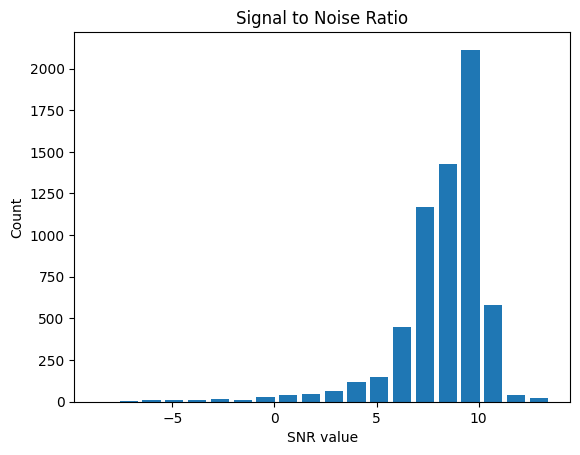

In [34]:
plt.hist(df['snr'], bins =20, histtype='bar', rwidth=0.8)
plt.title('Signal to Noise Ratio')
plt.xlabel('SNR value')
plt.ylabel('Count')
plt.show()

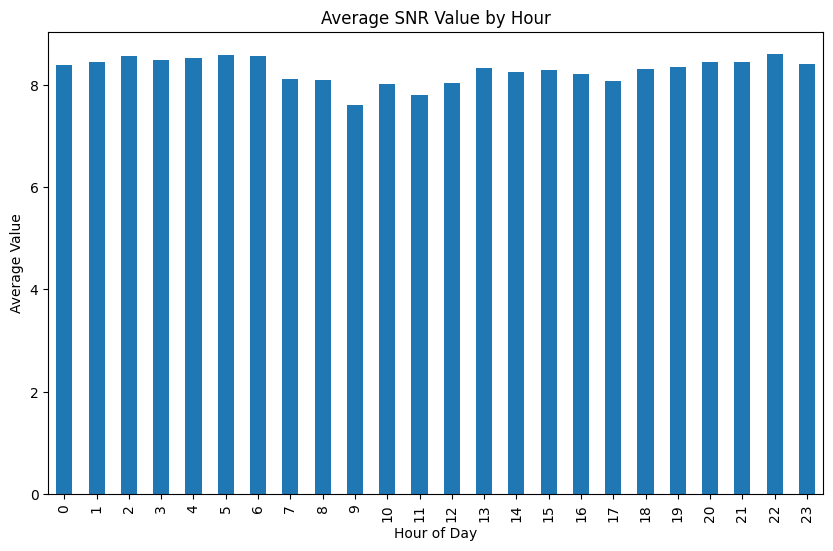

In [35]:
# Grouping the mean SNR value by hour
hourly_mean_snr = df.groupby('hour')['snr'].mean()

# Plotting
hourly_mean_snr.plot(kind='bar', figsize=(10, 6))
plt.title('Average SNR Value by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Value')
plt.show()

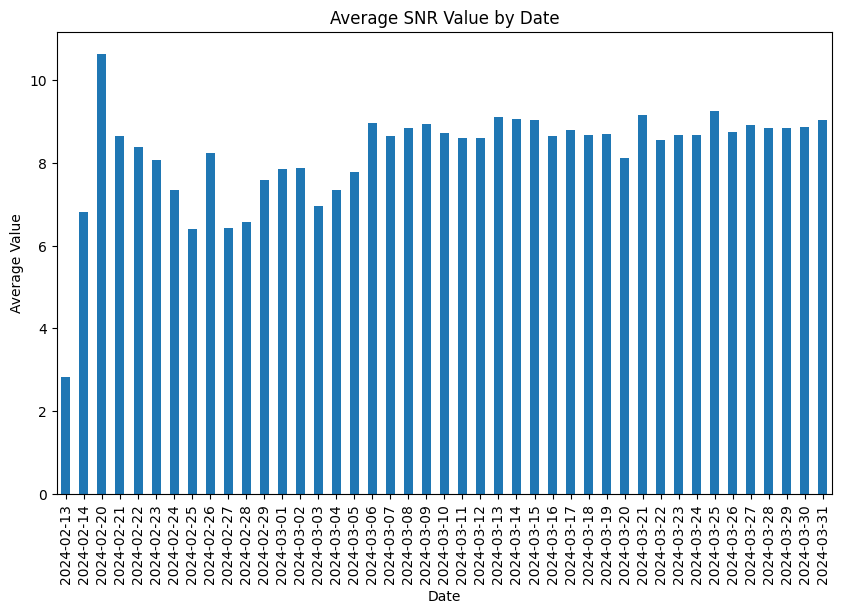

In [36]:
# Grouping the mean SNR value by date
daily_mean_snr = df.groupby('date')['snr'].mean()

# Plotting
daily_mean_snr.plot(kind='bar', figsize=(10, 6))
plt.title('Average SNR Value by Date')
plt.xlabel('Date')
plt.ylabel('Average Value')
plt.xticks(rotation=90)
plt.show()

### RSSI

Signal strength – the higher value, the better the signal quality

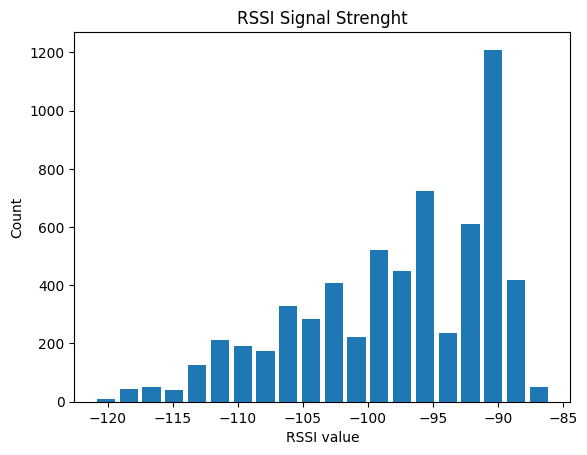

In [37]:
plt.hist(df['rssi'], bins =20, histtype='bar', rwidth=0.8)
plt.title('RSSI Signal Strenght')
plt.xlabel('RSSI value')
plt.ylabel('Count')
plt.show()

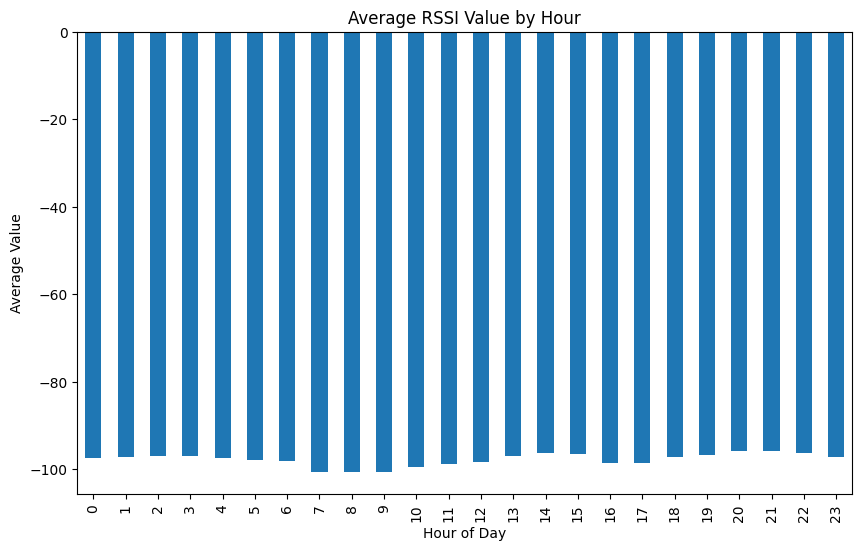

In [38]:
# Grouping the mean RSSI value by hour
hourly_mean_rssi = df.groupby('hour')['rssi'].mean()

# Plotting
hourly_mean_rssi.plot(kind='bar', figsize=(10, 6))
plt.title('Average RSSI Value by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Value')
plt.show()

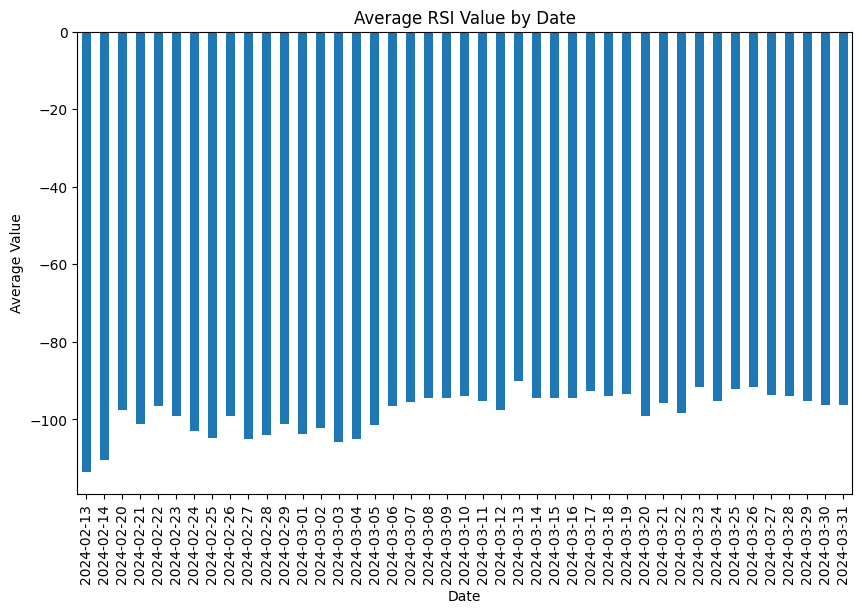

In [39]:
# Grouping the mean SNR value by hour
daily_mean_rssi = df.groupby('date')['rssi'].mean()

# Plotting
daily_mean_rssi.plot(kind='bar', figsize=(10, 6))
plt.title('Average RSI Value by Date')
plt.xlabel('Date')
plt.ylabel('Average Value')
plt.xticks(rotation=90)
plt.show()

### Battery variable

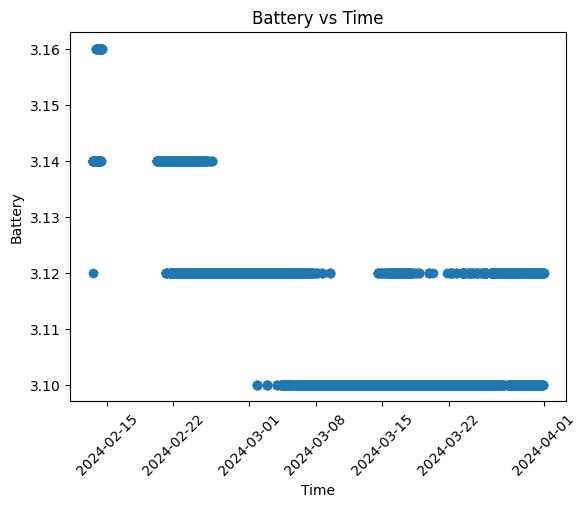

In [40]:
# here I want to plot variable 'battery':
plt.figure()
plt.scatter(x=df["time"] , y=df["battery"])
plt.title('Battery vs Time')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('Battery')
plt.show()

### Temperature

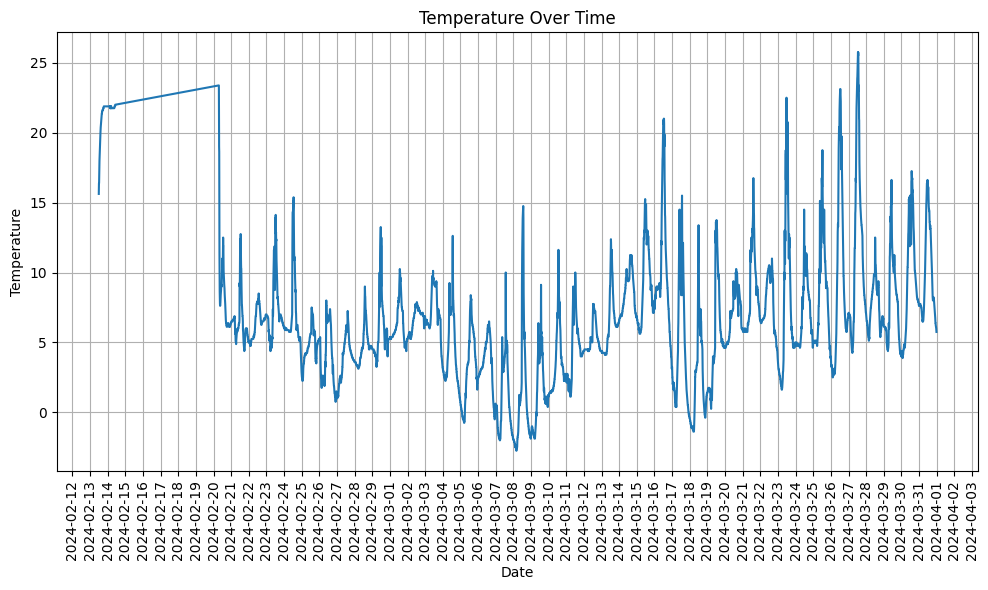

In [41]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['temperature'], linestyle='-')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.xticks(rotation=90)
plt.grid(True)

# Set x-axis major locator and formatter
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()

In [42]:
# Creating a new dataset including only time and temperature
df_temperature = df[["time", "temperature"]]

# Setting the datetime variable as index
df_temperature = df_temperature.set_index(['time'])
df_temperature.head()

,temperature
time,
2024-02-13 11:53:30.800,15.62
2024-02-13 12:07:56.910,16.38
2024-02-13 12:17:54.246,16.38
2024-02-13 12:27:55.246,16.88
2024-02-13 12:37:57.246,17.25


In [43]:
# Resampling the temperature dataset on hour
df_temperature_hourly = df_temperature.resample("H").mean()
df_temperature_hourly.head()

,temperature
time,
2024-02-13 11:00:00,15.620000
2024-02-13 12:00:00,17.148333
2024-02-13 13:00:00,19.413333
2024-02-13 14:00:00,20.271667
2024-02-13 15:00:00,21.041667


In [44]:
# Plotting the average temperature each hour
alt.Chart((df_temperature_hourly).reset_index()).mark_rect().encode(
    alt.X('hoursminutes(time):O', title='hour of day'),
    alt.Y('monthdate(time):O', title='date'),
    alt.Color('temperature:Q', title='temperature')
)

alt.Chart(...)

/tmp/ipykernel_3896/2660148259.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_specific_time_range[['x', 'y', 'z']] = normalized_data


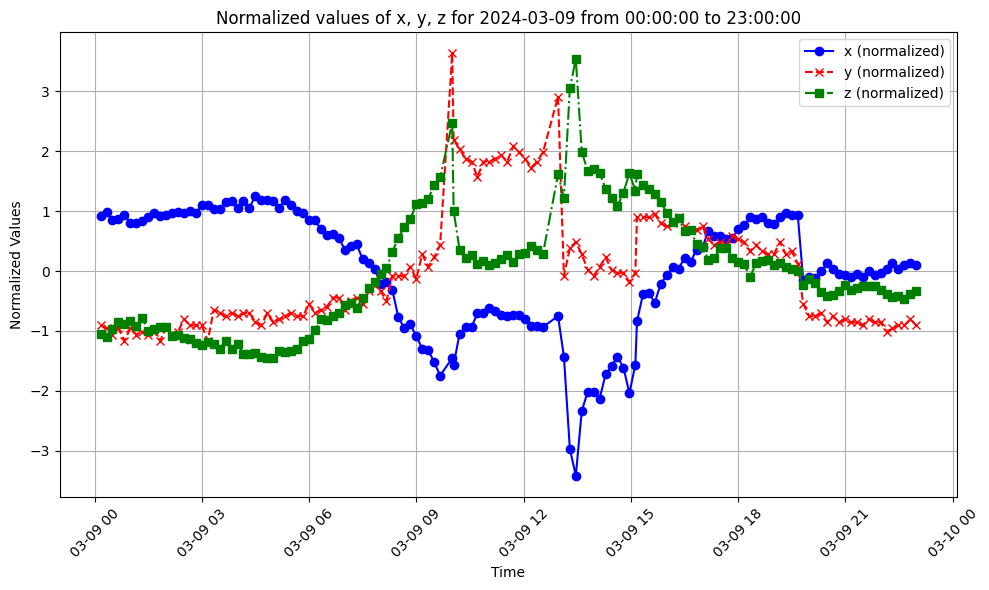

In [68]:
# Convert 'time' column to datetime if it's not already in datetime format
df['time'] = pd.to_datetime(df['time'])

# Specify the date and time range
specific_date = '2024-03-09'
start_time = '00:00:00'
end_time = '23:00:00'

# Filter the DataFrame for the specific date and time range
df_specific_time_range = df[(df['time'].dt.date == pd.to_datetime(specific_date).date()) &
                            (df['time'].dt.time >= pd.to_datetime(start_time).time()) &
                            (df['time'].dt.time <= pd.to_datetime(end_time).time())]

# Selecting the columns to be normalized
data_to_normalize = df_specific_time_range[['x', 'y', 'z']]

# Applying StandardScaler
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data_to_normalize)

# Adding normalized data back to the DataFrame
df_specific_time_range[['x', 'y', 'z']] = normalized_data

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_specific_time_range['time'], df_specific_time_range['x'], label='x (normalized)', color='blue', marker='o', linestyle='-')
plt.plot(df_specific_time_range['time'], df_specific_time_range['y'], label='y (normalized)', color='red', marker='x', linestyle='--')
plt.plot(df_specific_time_range['time'], df_specific_time_range['z'], label='z (normalized)', color='green', marker='s', linestyle='-.')
plt.title(f'Normalized values of x, y, z for {specific_date} from {start_time} to {end_time}')
plt.xlabel('Time')
plt.ylabel('Normalized Values')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 5. Unsupervised Machine Learning

### 5.1 UML: Magnetic field data

In this section we'll...

In [46]:
# Saving the magnetic field data in a new dataframe 
mag = df[["x","y","z"]]

In [47]:
# Normalizing the data
scaler = StandardScaler()
mag_normalized = scaler.fit_transform(mag)

In [48]:
print(mag_normalized)

[[-0.64123659 -0.02740138  0.50845212]
 [-1.50696545 -0.11032888  0.38226838]
 [-1.5980948  -0.10394985  0.45293127]
 ...
 [ 0.25183108 -0.15498216  0.74567754]
 [ 0.27005695 -0.14860312  0.72548815]
 [ 0.26094401 -0.129466    0.72548815]]


In [49]:
# Clustering the magnetic field data
kmeans = KMeans(n_clusters=2, random_state=0).fit(mag_normalized)

# Adding cluster labels to the mag dataframe
mag['mag_cluster'] = kmeans.labels_

# Checking the result
mag.sample(5)

/tmp/ipykernel_3896/64798676.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mag['mag_cluster'] = kmeans.labels_


,x,y,z,mag_cluster
3012,801,-622,-655,0
2609,793,-652,-701,0
5735,684,-626,-466,0
2534,755,-652,-634,0
4039,687,-628,-574,0


<BarContainer object of 2 artists>

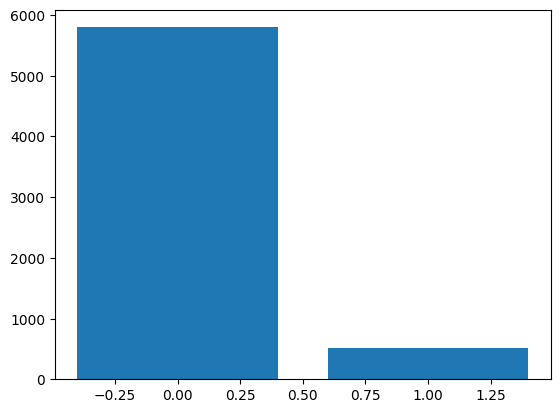

In [50]:
# Checking distribution of different values in mag_cluster values in barplot   
plt.bar(np.arange(2), mag['mag_cluster'].value_counts().values, align='center') # plot histogram for x and y data

**Silhouette score**

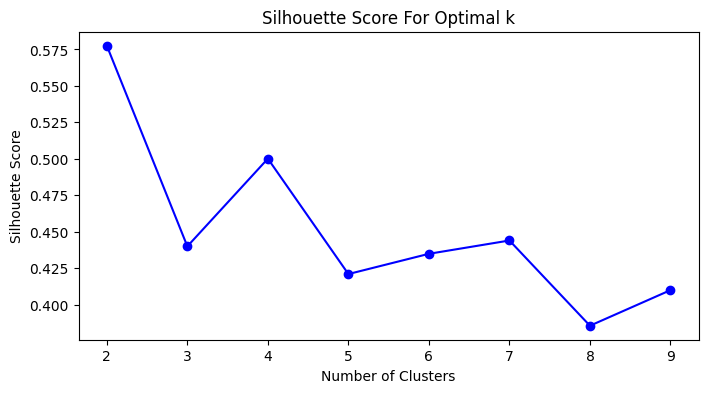

In [51]:
silhouette_avg = []
for k in range(2, 10):  # Starts from 2 clusters 
    kmeans = KMeans(n_clusters=k, random_state=0).fit(mag_normalized)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(mag_normalized, cluster_labels))

plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), silhouette_avg, 'bo-')  # Adjust the range as needed
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.show()

**Elbow method**

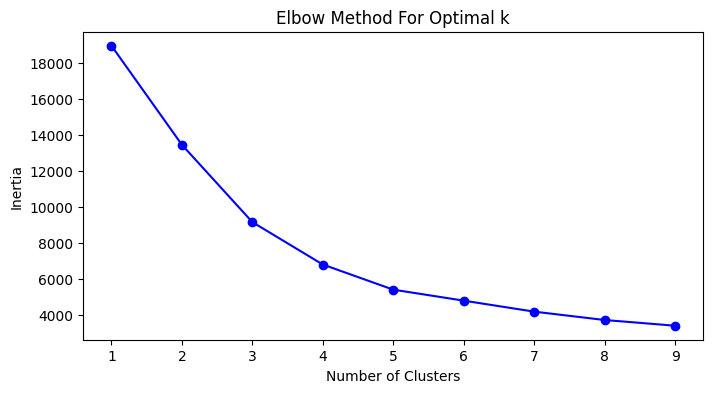

In [52]:
inertia = []
for k in range(1, 10):  
    kmeans = KMeans(n_clusters=k, random_state=0).fit(mag_normalized)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), inertia, 'bo-') 
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

**Visualising the clusters**

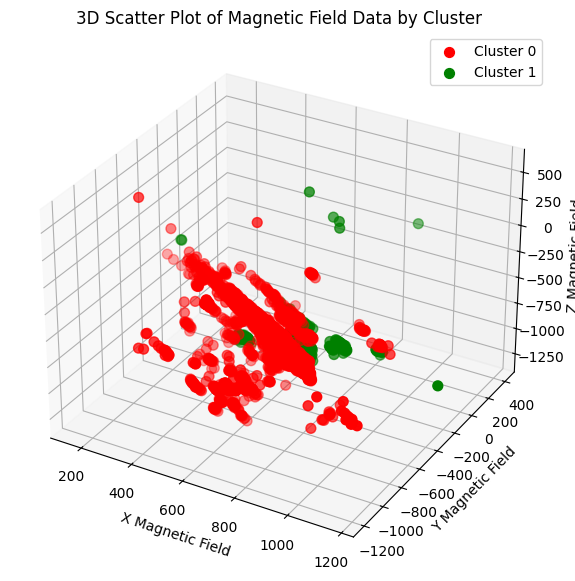

In [53]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# List of colors, ensure you have enough colors for your clusters
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'orange', 'pink', 'lightblue', 'lightgreen']

# Loop through each cluster 
for i in mag['mag_cluster'].unique():
    # Extract data points belonging to the current cluster
    cluster_data = mag[mag['mag_cluster'] == i]
    ax.scatter(cluster_data['x'], cluster_data['y'], cluster_data['z'], s=50, color=colors[i], label=f'Cluster {i}')

ax.set_xlabel('X Magnetic Field')
ax.set_ylabel('Y Magnetic Field')
ax.set_zlabel('Z Magnetic Field')
ax.set_title('3D Scatter Plot of Magnetic Field Data by Cluster')
ax.legend()
plt.show()

### 5.2 UML - Radar Data

In [54]:
# Saving the radar data in a new dataframe
rad = df[['0_radar', '1_radar',
       '2_radar', '3_radar', '4_radar', '5_radar', '6_radar', '7_radar']]

In [55]:
# Normalize the data
scaler = StandardScaler()
rad_normalized = scaler.fit_transform(rad)

In [56]:
# Clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(rad_normalized)

# Adding cluster labels to original data
rad['rad_cluster'] = kmeans.labels_

# Checking the result
rad.head()

/tmp/ipykernel_3896/1010965370.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rad['rad_cluster'] = kmeans.labels_


,0_radar,1_radar,2_radar,3_radar,4_radar,5_radar,6_radar,7_radar,rad_cluster
0,10,5,6,6,7,7,5,5,0
1,9,6,4,5,6,6,5,4,0
2,10,5,5,5,8,7,5,4,0
3,10,5,5,5,8,7,5,4,0
4,10,5,5,5,8,7,5,4,0


<BarContainer object of 2 artists>

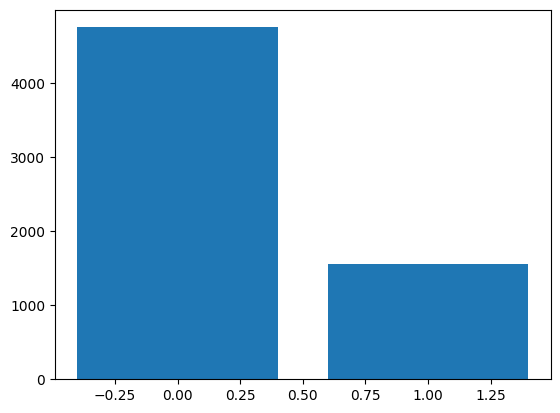

In [57]:
# Checking distribution of different values in mag_cluster values in barplot 
plt.bar(np.arange(2), rad['rad_cluster'].value_counts().values, align='center') 

### 5.3 Adding clusters to original data

In [58]:
# Adding the clusters to the original dataframe
df['mag_cluster'] = mag['mag_cluster']
df['rad_cluster'] = rad['rad_cluster']
df.head()

,time,battery,temperature,x,y,z,0_radar,1_radar,2_radar,3_radar,...,dr,snr,rssi,date,hour,day_of_week,day_name,package_type_encoded,mag_cluster,rad_cluster
0,2024-02-13 11:53:30.800,3.12,15.62,620,-618,-532,10,5,6,6,...,0,5.8,-106,2024-02-13,11,1,Tuesday,0,0,0
1,2024-02-13 12:07:56.910,3.14,16.38,525,-631,-557,9,6,4,5,...,0,7.2,-108,2024-02-13,12,1,Tuesday,0,0,0
2,2024-02-13 12:17:54.246,3.14,16.38,515,-630,-543,10,5,5,5,...,0,-4.2,-102,2024-02-13,12,1,Tuesday,1,0,0
3,2024-02-13 12:27:55.246,3.14,16.88,508,-625,-541,10,5,5,5,...,0,-4.2,-102,2024-02-13,12,1,Tuesday,1,0,0
4,2024-02-13 12:37:57.246,3.14,17.25,501,-627,-529,10,5,5,5,...,0,-4.2,-102,2024-02-13,12,1,Tuesday,1,0,0


We'll also make a new column showing the difference between the two clusterings

In [59]:
# Cluster is different
df['dif_cluster'] = df['mag_cluster'] == df['rad_cluster']

<BarContainer object of 2 artists>

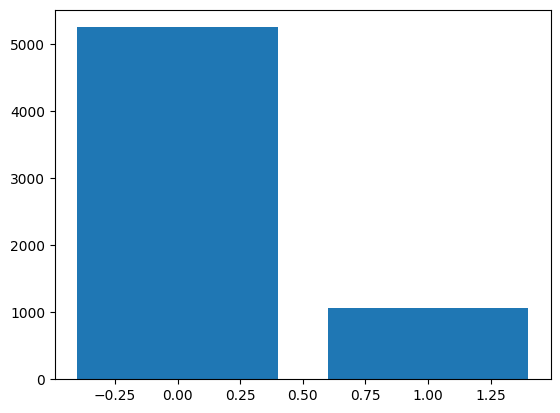

In [60]:
plt.bar(np.arange(2), df['dif_cluster'].value_counts().values, align='center') 